In [1]:
import torch.nn as nn
import torch

import sys, os
import random
import numpy as np
from shutil import copy
import matplotlib.pyplot as plt
from copy import deepcopy

from omegaconf import OmegaConf
import shutil
import pickle
import random
from tqdm import tqdm

from torchvision.datasets.folder import ImageFolder
from torch.utils.data import DataLoader
from skimage.filters import threshold_local, gaussian

import pdb

In [2]:
# run_path = '/home/harishbabu/projects/PIPNet/runs/010-CUB-27-imgnet_OOD_cnext26_img=224_nprotos=20'
# run_path = '/home/harishbabu/projects/PIPNet/runs/031-CUB-18-imgnet_cnext26_img=224_nprotos=20_orth-on-rel'
# run_path = '/home/harishbabu/projects/PIPNet/runs/032-CUB-18-imgnet_cnext26_img=224_nprotos=20_orth-on-rel'

# run_path = '/home/harishbabu/projects/PIPNet/runs/035-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20_orth-on-rel'

# run_path = '/home/harishbabu/projects/PIPNet/runs/043-035_clone-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20_orth-on-rel'
# run_path = "/home/harishbabu/projects/PIPNet/runs/036-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20_orth-on-rel_uniformity"
# run_path = "/home/harishbabu/projects/PIPNet/runs/041-035_clone-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20_orth-on-rel"
# run_path = "/home/harishbabu/projects/PIPNet/runs/042-035_clone-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20_orth-on-rel"

# run_path = "/home/harishbabu/projects/PIPNet/runs/044-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20-or-4per-desc_orth-on-rel"

# run_path = "/home/harishbabu/projects/PIPNet/runs/046-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=10per-desc_orth-on-rel"
# run_path = "/home/harishbabu/projects/PIPNet/runs/047-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=5per-desc_tanh-desc"
# run_path = "/home/harishbabu/projects/PIPNet/runs/048-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=5per-desc_tanh-desc_unit-sphere"
# run_path = "/home/harishbabu/projects/PIPNet/runs/051-CUB-18-imgnet_cnext26_img=224_nprotos=4per-desc_tanh-desc_unit-sphere_AW=5-TW=2-UW=2-CW=2"
# run_path = "/home/harishbabu/projects/PIPNet/runs/052-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=4per-desc_tanh-desc_unit-sphere_AW=5-TW=2-UW=2-CW=2"
# run_path = "/home/harishbabu/projects/PIPNet/runs/055-CUB-18_cnext26_img=224_nprotos=4per-desc_unit-sphere_no-softmax_AW=3-TW=2-UW=3-CW=2"
# run_path = "/home/harishbabu/projects/PIPNet/runs/056-CUB-18-imgnet_cnext26_img=224_nprotos=4per-desc_unit-sphere_no-softmax_AW=3-TW=2-UW=3-CW=2"
# run_path = "/home/harishbabu/projects/PIPNet/runs/057-CUB-18-imgnet_cnext26_img=224_nprotos=4per-desc_unit-sphere_no-meanpool_no-softmax_AW=3-TW=2-UW=3-CW=2"
# run_path = "/home/harishbabu/projects/PIPNet/runs/058-CUB-18-imgnet_with-equalize-aug_cnext26_img=224_nprotos=4per-desc_unit-sphere_no-meanpool_no-softmax_AW=3-TW=2-UW=3-CW=2"

# with unit sphere
# run_path = "/home/harishbabu/projects/PIPNet/runs/059-CUB-18-imgnet_with-equalize-aug_cnext26_img=224_nprotos=4per-desc_unit-sphere_finetune=5_no-meanpool_no-softmax_AW=3-TW=2-UW=3-CW=2_batch=20"

# unit sphere with softmax
# run_path = "/home/harishbabu/projects/PIPNet/runs/065-CUB-18-imgnet_with-equalize-aug_cnext26_img=224_nprotos=4per-desc_unit-sphere_finetune=5_no-meanpool_with-softmax_AW=3-TW=2-UW=3-CW=2_batch=20"

# original hpipnet with 20 protos per node no KO, no OOD, no tanh-desc
run_path = "/home/harishbabu/projects/PIPNet/runs/062-CUB-18-imgnet_with-equalize-aug_cnext26_img=224_nprotos=20_no-KO_no-OOD"

# original hpipnet with 20 protos per node no KO, no OOD, WITH tanh-desc
# run_path = "/home/harishbabu/projects/PIPNet/runs/063-CUB-18-imgnet_with-equalize-aug_cnext26_img=224_nprotos=20_no-KO_no-OOD_tanh-desc"

# with unit sphere but no AL+UNI
# run_path = "/home/harishbabu/projects/PIPNet/runs/066-CUB-18-imgnet_with-equalize-aug_cnext26_img=224_nprotos=4per-desc_unit-sphere_finetune=5_no-meanpool_no-softmax_no-align_no-uni_AW=3-TW=2-UW=3-CW=2_batch=20"

# with unit sphere, protopool, with softmax, no tanh-desc
# run_path = "/home/harishbabu/projects/PIPNet/runs/067-CUB-18-imgnet_with-equalize-aug_cnext26_img=224_nprotos=4per-desc_unit-sphere-protopool_finetune=5_no-meanpool_with-softmax_AW=3-TW=2-UW=3-CW=2_batch=20"

# with unit sphere, protopool, with softmax, no tanh-desc, INCORRECT
# run_path = "/home/harishbabu/projects/PIPNet/runs/067-incorrect-CUB-18-imgnet_with-equalize-aug_cnext26_img=224_nprotos=4per-desc_unit-sphere-protopool_finetune=5_no-meanpool_with-softmax_AW=3-TW=2-UW=3-CW=2_batch=20"

# with unit sphere, protopool, no softmax, no tanh-desc
# run_path = "/home/harishbabu/projects/PIPNet/runs/068-CUB-18-imgnet_with-equalize-aug_cnext26_img=224_nprotos=4per-desc_unit-sphere-protopool_finetune=5_no-meanpool_no-softmax_AW=3-TW=2-UW=3-CW=2_batch=20"

# 071 with bias
# run_path = "/home/harishbabu/projects/PIPNet/runs/071-CUB-18-imgnet_with-equalize-aug_cnext26_img=224_nprotos=4per-desc_unit-sphere-protopool_finetune=5_no-meanpool_with-softmax_with-addon-bias_AW=3-TW=2-UW=3-CW=2_batch=20"

# 072 gumbel softmax
# run_path = "/home/harishbabu/projects/PIPNet/runs/072-CUB-18-imgnet_with-equalize-aug_cnext26_img=224_nprotos=4per-desc_unit-sphere-protopool_finetune=5_no-meanpool_with-gumbel-softmax_no-addon-bias_AW=3-TW=2-UW=3-CW=2_batch=20"

# 073 gumbel softmax, tau-1.0
# run_path = "/home/harishbabu/projects/PIPNet/runs/073-CUB-18-imgnet_with-equalize-aug_cnext26_img=224_nprotos=4per-desc_unit-sphere-protopool_finetune=5_no-meanpool_with-gumbel-softmax-tau=1_no-addon-bias_AW=3-TW=2-UW=3-CW=2_batch=20"

# 075 068 with focal loss
# run_path = "/home/harishbabu/projects/PIPNet/runs/075-068-with-focal_CUB-18-imgnet_with-equalize-aug_cnext26_img=224_nprotos=4per-desc_unit-sphere-protopool_finetune=5_no-meanpool_no-softmax_no-addon-bias_AW=3-TW=2-UW=3-CW=2_batch=20"

# 076 cs followed by softmax. Uses align_pf along with align+uni
# run_path = "/home/harishbabu/projects/PIPNet/runs/076_CUB-18-imgnet_with-equalize-aug_cnext26_img=224_nprotos=4per-desc_unit-sphere-protopool_finetune=5_align-pf-during-training_no-meanpool_no-softmax_no-addon-bias_AW=3-TW=2-UW=3-CW=2-APW=5_batch=20"

# 074 multiply_cs_softmax
# run_path = "/home/harishbabu/projects/PIPNet/runs/074-CUB-18-imgnet_with-equalize-aug_cnext26_img=224_nprotos=4per-desc_unit-sphere-protopool_finetune=5_no-meanpool_with-softmax_multi-cs-softmax_no-addon-bias_AW=3-TW=2-UW=3-CW=2_batch=20"

# 077 unit sphere protopool with cosin no softmax constant 20 protos per node
# run_path = "/home/harishbabu/projects/PIPNet/runs/077_CUB-18-imgnet_with-equalize-aug_cnext26_img=224_nprotos=20-sphere-protopool_finetune=5_align-pf-during-training_no-meanpool_no-softmax_no-addon-bias_AW=3-TW=2-UW=3-CW=2_batch=20"

# 082 unit sphere cs followed by softmax with minmazimize loss
# run_path = "/home/harishbabu/projects/PIPNet/runs/082-CUB-18-imgnet_with-equalize-aug_cnext26_img=224_nprotos=4per-leaf-desc_unit-sphere_finetune=5_no-meanpool_with-softmax_no-addon-bias_AW=3-TW=2-MMW=2-UW=3-CW=2_mm-loss_batch=48"

# 083 unit sphere cs followed by softmax with minmazimize loss
# run_path = "/home/harishbabu/projects/PIPNet/runs/083-CUB-18-imgnet_with-equalize-aug_cnext26_img=224_nprotos=4per-leaf-desc_unit-sphere_finetune=5_no-meanpool_with-softmax_no-addon-bias_AW=3-TW=2-MMW=2-UW=3-CW=2_no-align_no-uni_no-mm-loss_batch=48"

# 085 unit sphere cs followed by softmax-with-tau with minmazimize loss
# run_path = "/home/harishbabu/projects/PIPNet/runs/085-notebook-CUB-18-imgnet_with-equalize-aug_cnext26_img=224_nprotos=4per-leaf-desc_unit-sphere_finetune=5_no-meanpool_with-softmax-tau=0.2_no-addon-bias_AW=3-TW=2-MMW=2-UW=3-CW=2_mm-loss_batch=12"

# 091 basic gaussian multiplier on stage 4
# run_path = "/home/harishbabu/projects/PIPNet/runs/091-CUB-18-imgnet_with-equalize-aug_cnext26_BGM=4|1.0|50_img=224_latent-dim=256_nprotos=4per-leaf-desc_unit-sphere_finetune=5_no-meanpool_with-softmax-tau=0.2_no-addon-bias_AW=3-TW=2-MMW=2-UW=3-CW=2_mm-loss_batch=48"

# 092 basic gaussian multiplier on stage 3, 4
# run_path = "/home/harishbabu/projects/PIPNet/runs/092-CUB-18-imgnet_with-equalize-aug_cnext26_BGM=3,4|1.0|50_img=224_latent-dim=256_nprotos=4per-leaf-desc_unit-sphere_finetune=5_no-meanpool_with-softmax-tau=0.2_no-addon-bias_AW=3-TW=2-MMW=2-UW=3-CW=2_mm-loss_batch=48"

# 093 128 dim linear
# run_path = "/home/harishbabu/projects/PIPNet/runs/093-CUB-18-imgnet_with-equalize-aug_cnext26_BGM=4|1.0|50_img=224_latent-dim=128_nprotos=20_unit-sphere_finetune=5_no-meanpool_with-softmax-tau=0.2_no-addon-bias_AW=3-TW=2-MMW=2-UW=1-CW=2_mm-loss_batch=48"

# 094 128 dim linear
# run_path = "/home/harishbabu/projects/PIPNet/runs/094-CUB-18-imgnet_with-equalize-aug_cnext26_BGM=4|1.0|50_img=224_latent-dim=128_nprotos=20_unit-sphere_finetune=5_no-meanpool_with-softmax-tau=0.2_no-addon-bias_AW=3-TW=2-MMW=2-UW=1-CW=2_mm-loss_batch=48"

# 095 ablation 091 without AL+UNI
# run_path = "/home/harishbabu/projects/PIPNet/runs/095-091-woALUNI-CUB-18-imgnet_with-equalize-aug_cnext26_BGM=4|1.0|50_img=224_nprotos=4per-leaf-desc_unit-sphere_finetune=5_no-meanpool_with-softmax-tau=0.2_no-addon-bias_AW=3-TW=2-MMW=2-UW=3-CW=2_no-AL_no-UNI_mm-loss_batch=48"

# 096 ablation 091 without AL+UNI
# run_path = "/home/harishbabu/projects/PIPNet/runs/096-091-wfocal-CUB-18-imgnet_with-equalize-aug_cnext26_BGM=4|1.0|50_img=224_nprotos=4per-leaf-desc_unit-sphere_finetune=5_no-meanpool_with-softmax-tau=0.2_no-addon-bias_AW=3-TW=2-MMW=2-UW=3-CW=2_mm-loss_batch=48"

# 097 - 091 with bg
# run_path = "/home/harishbabu/projects/PIPNet/runs/097-091-wbg-CUB-18_with-equalize-aug_cnext26_BGM=4|1.0|50_img=224_nprotos=4per-leaf-desc_unit-sphere_finetune=5_no-meanpool_with-softmax-tau=0.2_no-addon-bias_AW=3-TW=2-MMW=2-UW=3-CW=2_mm-loss_batch=48"

# 0100 cub29 with 20 per node
# run_path = "/home/harishbabu/projects/PIPNet/runs/100_CUB-29-imgnet_with-equalize-aug_cnext26_BGM=4|1.0|50_img=224_nprotos=20_unit-sphere-protopool_no-meanpool_with-softmax-tau=0.2_no-addon-bias_AW=3-TW=2-MMW=2-UW=3-CW=2_mm-loss_batch=48"

# 0101 baseline with 4 per desc per node
# run_path = "/home/harishbabu/projects/PIPNet/runs/101-baseline-CUB-18-imgnet_with-equalize-aug_cnext26_img=224_nprotos=4per-desc_no-KO_no-OOD"

# 0103 091 with 20 per node
# run_path = "/home/harishbabu/projects/PIPNet/runs/103-091-wProtoPool20PerNode_CUB-18-imgnet_with-equalize-aug_cnext26_BGM=4|1.0|50_img=224_nprotos=20_unit-sphere-protopool_no-meanpool_with-softmax-tau=0.2_no-addon-bias_AW=3-TW=2-MMW=2-UW=3-CW=2_batch=48"

try:
    sys.path.remove('/home/harishbabu/projects/PIPNet')
except:
    pass
sys.path.insert(0, os.path.join(run_path, 'source_clone'))


In [3]:
from pipnet.pipnet import PIPNet, get_network
from util.log import Log
from util.args import get_args, save_args, get_optimizer_nn
from util.data import get_dataloaders
from util.func import init_weights_xavier
from pipnet.train import train_pipnet, test_pipnet
# from pipnet.test import eval_pipnet, get_thresholds, eval_ood
from util.eval_cub_csv import eval_prototypes_cub_parts_csv, get_topk_cub, get_proto_patches_cub
from util.vis_pipnet import visualize, visualize_topk
from util.visualize_prediction import vis_pred, vis_pred_experiments
from util.node import Node
from util.phylo_utils import construct_phylo_tree, construct_discretized_phylo_tree
from util.func import get_patch_size
from util.data import ModifiedLabelLoader

# Load model

In [4]:
args_file = open(os.path.join(run_path, 'metadata', 'args.pickle'), 'rb')
args = pickle.load(args_file)

if args.phylo_config:
    phylo_config = OmegaConf.load(args.phylo_config)

if args.phylo_config:
    # construct the phylo tree
    if phylo_config.phyloDistances_string == 'None':
        if '031' in run_path: # this run uses a different phylogeny file that had an extra root node which is a mistake
            root = construct_phylo_tree('/home/harishbabu/data/phlyogenyCUB/18Species-with-extra-root-node/1_tree-consensus-Hacket-18Species-modified_cub-names_v1.phy')
        else:
            root = construct_phylo_tree(phylo_config.phylogeny_path)
        print('-'*25 + ' No discretization ' + '-'*25)
    else:
        root = construct_discretized_phylo_tree(phylo_config.phylogeny_path, phylo_config.phyloDistances_string)
        print('-'*25 + ' Discretized ' + '-'*25)
else:
    # construct the tree (original hierarchy as described in the paper)
    root = Node("root")
    root.add_children(['animal','vehicle','everyday_object','weapon','scuba_diver'])
    root.add_children_to('animal',['non_primate','primate'])
    root.add_children_to('non_primate',['African_elephant','giant_panda','lion'])
    root.add_children_to('primate',['capuchin','gibbon','orangutan'])
    root.add_children_to('vehicle',['ambulance','pickup','sports_car'])
    root.add_children_to('everyday_object',['laptop','sandal','wine_bottle'])
    root.add_children_to('weapon',['assault_rifle','rifle'])
    # flat root
    # root.add_children(['scuba_diver','African_elephant','giant_panda','lion','capuchin','gibbon','orangutan','ambulance','pickup','sports_car','laptop','sandal','wine_bottle','assault_rifle','rifle'])
root.assign_all_descendents()

exp_no = int(os.path.basename(run_path)[:3])

if exp_no < 77:
    if ('num_protos_per_descendant' in args) and (args.num_protos_per_descendant > 0):
        for node in root.nodes_with_children():
            node.set_num_protos(args.num_protos_per_descendant)
else:
    if ('num_protos_per_descendant' in args):
        # update num of protos per node based on num_protos_per_descendant
        if args.num_features == 0 and args.num_protos_per_descendant == 0:
            raise Exception('Either of num_features or num_protos_per_descendant must be greater than zero')
        for node in root.nodes_with_children():
            node.set_num_protos(num_protos_per_descendant=args.num_protos_per_descendant,\
                                min_protos=args.num_features,\
                                split_protos=('protopool' in args) and (args.protopool == 'n'))

------------------------- No discretization -------------------------


In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    device_ids = [torch.cuda.current_device()]
else:
    device = torch.device('cpu')
    device_ids = []

# args_file = open(os.path.join(run_path, 'metadata', 'args.pickle'), 'rb')
# args = pickle.load(args_file)

# ckpt_file_name = 'net_overspecific_pruned_replaced_thresh=0.5_last'
ckpt_file_name = 'net_trained_last'
# ckpt_file_name = 'net_trained_10'
# ckpt_file_name = 'net_pretrained'
epoch = ckpt_file_name.split('_')[-1]

ckpt_path = os.path.join(run_path, 'checkpoints', ckpt_file_name)
checkpoint = torch.load(ckpt_path, map_location=device)

if ckpt_file_name != 'net_trained_last':
    print('\n', (10*'-')+'WARNING: Not using the final trained model'+(10*'-'), '\n')

# Obtain the dataset and dataloaders
trainloader, trainloader_pretraining, trainloader_normal, trainloader_normal_augment, projectloader, testloader, test_projectloader, classes = get_dataloaders(args, device)

print(args.batch_size, trainloader.batch_size)

if len(classes)<=20:
    if args.validation_size == 0.:
        print("Classes: ", testloader.dataset.class_to_idx, flush=True)
    else:
        print("Classes: ", str(classes), flush=True)

# Create a convolutional network based on arguments and add 1x1 conv layer
feature_net, add_on_layers, pool_layer, classification_layers, num_prototypes = get_network(len(classes), args, root=root)
   
# Create a PIP-Net
net = PIPNet(num_classes=len(classes),
                    num_prototypes=num_prototypes,
                    feature_net = feature_net,
                    args = args,
                    add_on_layers = add_on_layers,
                    pool_layer = pool_layer,
                    classification_layers = classification_layers,
                    num_parent_nodes = len(root.nodes_with_children()),
                    root = root
                    )
net = net.to(device=device)
net = nn.DataParallel(net, device_ids = device_ids)    
net.load_state_dict(checkpoint['model_state_dict'],strict=True)
print(net.eval())
criterion = nn.NLLLoss(reduction='mean').to(device)

# Forward one batch through the backbone to get the latent output size
# with torch.no_grad():
#     xs1, _, _ = next(iter(trainloader))
#     xs1 = xs1.to(device)
#     proto_features, _, _ = net(xs1)
#     wshape = proto_features['root'].shape[-1]
#     args.wshape = wshape #needed for calculating image patch size
#     print("Output shape: ", proto_features['root'].shape, flush=True)
    
args.wshape = 26

Num classes (k) =  18 ['cub_001_Black_footed_Albatross', 'cub_002_Laysan_Albatross', 'cub_003_Sooty_Albatross', 'cub_004_Groove_billed_Ani', 'cub_023_Brandt_Cormorant'] etc.
64 64
Classes:  {'cub_001_Black_footed_Albatross': 0, 'cub_002_Laysan_Albatross': 1, 'cub_003_Sooty_Albatross': 2, 'cub_004_Groove_billed_Ani': 3, 'cub_023_Brandt_Cormorant': 4, 'cub_024_Red_faced_Cormorant': 5, 'cub_025_Pelagic_Cormorant': 6, 'cub_031_Black_billed_Cuckoo': 7, 'cub_032_Mangrove_Cuckoo': 8, 'cub_033_Yellow_billed_Cuckoo': 9, 'cub_045_Northern_Fulmar': 10, 'cub_050_Eared_Grebe': 11, 'cub_051_Horned_Grebe': 12, 'cub_052_Pied_billed_Grebe': 13, 'cub_053_Western_Grebe': 14, 'cub_086_Pacific_Loon': 15, 'cub_100_Brown_Pelican': 16, 'cub_101_White_Pelican': 17}
Number of prototypes:  20
Assigned 20 protos to node root
Assigned 20 protos to node 052+053
Assigned 20 protos to node 004+086
Assigned 20 protos to node 053+050
Assigned 20 protos to node 004+032
Assigned 20 protos to node 086+045
Assigned 20 prot

In [23]:
from collections import defaultdict
import csv
import pandas as pd
import csv
import numpy as np
import pandas as pd
import os
from PIL import Image
from tqdm import tqdm
import torch
from util.func import get_patch_size
import csv
import torchvision.transforms as transforms
import torchvision
from util.vis_pipnet import get_img_coordinates

def get_topk_cub_nodewise(net, node, projectloader, k, epoch, device, args):    

    if isinstance(projectloader.sampler, torch.utils.data.RandomSampler):
        raise Exception('Dataset should not be in shuffle')
    # Make sure the model is in evaluation mode
    net.eval()

    modifiedLabelLoader = ModifiedLabelLoader(projectloader, node)
    coarse_label2name = modifiedLabelLoader.modifiedlabel2name
    node_label_to_children = {label: name for name, label in node.children_to_labels.items()}
    project_iter = tqdm(enumerate(modifiedLabelLoader),
                        total=len(modifiedLabelLoader),
                        desc='Collecting top-k Prototypes CUB parts for '  + node.name,
                        mininterval=50.,
                        ncols=0)
    # IMPORTANT: dataloader should NOT be in shuffle, because imgs will not be shuffled, indexing wont be right
    imgs = modifiedLabelLoader.filtered_imgs
    if type(projectloader.dataset) == ImageFolder:
        name2label = projectloader.dataset.class_to_idx
        label2name = {label:name for name, label in name2label.items()}
    else:
        name2label = projectloader.dataset.dataset.dataset.class_to_idx
        label2name = {label:name for name, label in name2label.items()}
    
    # # Show progress on progress bar
    # project_iter = tqdm(enumerate(projectloader),
    #                     total=len(projectloader),
    #                     desc='Collecting top-k Prototypes CUB parts',
    #                     mininterval=50.,
    #                     ncols=0)
    # imgs = projectloader.dataset.imgs

    classification_weights = getattr(net.module, '_'+node.name+'_classification').weight
    # classification_weights = net.module._classification.weight

    patchsize, skip = get_patch_size(args)

    scores_per_prototype = defaultdict(lambda: defaultdict(list))
    # scores_per_prototype = dict()
    
    # Iterate through the projection set
    for i, (xs, orig_y, ys) in project_iter:
        xs, ys = xs.to(device), ys.to(device)

        coarse_label = ys.item()
        leaf_label = orig_y.item()

        # leaf_descendent = label2name[orig_y.item()][4:7]

        with torch.no_grad():
            # Use the model to classify this batch of input data
            pfs, pooled, _ = net(xs)
            pfs = pfs[node.name]
            pooled = pooled[node.name]
            pooled = pooled.squeeze(0) 
            pfs = pfs.squeeze(0) 
            for p in range(pooled.shape[0]):

                relevant_proto_classes = torch.nonzero(classification_weights[:, p] > 1e-3)
                relevant_proto_class_names = [node_label_to_children[class_idx.item()] for class_idx in relevant_proto_classes]

                #ignore prototypes that are not relevant to any class
                if len(relevant_proto_class_names) == 0:
                    continue

                if (coarse_label2name[coarse_label] in relevant_proto_class_names):
                    scores_per_prototype[p][leaf_label].append((i, pooled[p].item()))

                # c_weight = torch.max(classification_weights[:,p]) 
                # if c_weight > 1e-5:#ignore prototypes that are not relevant to any class
                #     # if p not in scores_per_prototype:
                #     #     scores_per_prototype[p] = []
                #     scores_per_prototype[p][leaf_descendent].append((i, pooled[p].item()))
    
    proto_img_coordinates = []
    csvfolderpath = os.path.join(args.log_dir, f'node_wise_top{k}')
    os.makedirs(csvfolderpath, exist_ok=True)
    csvfilepath = os.path.join(csvfolderpath, f'{node.name}_prototypes_top{k}_{str(epoch)}.csv')
    too_small = set()
    protoype_iter = tqdm(enumerate(scores_per_prototype.keys()), total=len(list(scores_per_prototype.keys())),mininterval=5.,ncols=0,desc='Collecting top-k patch coordinates CUB')
    with open(csvfilepath, "w", newline='') as csvfile:
        print("Writing CSV file with top k image patches..", flush=True)
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(["node", "child", "leaf", "prototype", \
                         "img name", "h_min_224", "h_max_224", \
                         "w_min_224", "w_max_224", "scores"])
        for _, prototype in protoype_iter:
            for leaf_label in scores_per_prototype[prototype]:
                leaf_descendent_name = label2name[leaf_label]
                child_name = node.closest_descendent_for(leaf_descendent_name).name
                leaf_descendent_name = leaf_descendent_name[4:7] # taking only the number from class name
                df = pd.DataFrame(scores_per_prototype[prototype][leaf_label], columns=['img_id', 'scores'])
                topk = df.nlargest(k, 'scores')
                for index, row in topk.iterrows():
                    imgid = int(row['img_id'])
                    imgname = imgs[imgid][0]
                    imgtensor = projectloader.dataset[imgid][0].unsqueeze(0)
                    with torch.no_grad():
                        # Use the model to classify this batch of input data
                        pfs, pooled, _ = net(imgtensor)
                        pfs = pfs[node.name]
                        pooled = pooled[node.name]
                        pfs = pfs.squeeze(0) 
                        pooled = pooled.squeeze(0)
                        if pooled[p].item() < 0.1:
                            too_small.add(p)
                        location_h, location_h_idx = torch.max(pfs[prototype,:,:], dim=0)
                        _, location_w_idx = torch.max(location_h, dim=0)
                        location = (location_h_idx[location_w_idx].item(), location_w_idx.item())
                        h_coor_min, h_coor_max, w_coor_min, w_coor_max = get_img_coordinates(args.image_size, pfs.shape, patchsize, skip, location[0], location[1])
                        proto_img_coordinates.append([node.name, child_name, leaf_descendent_name, \
                                                      prototype, imgname, h_coor_min, h_coor_max, \
                                                      w_coor_min, w_coor_max, row['scores']])
            # write intermediate results in case of large dataset
            if len(proto_img_coordinates)> 10000:
                writer.writerows(proto_img_coordinates) 
                proto_img_coordinates = []
        print("Warning: image patches included in topk, but similarity < 0.1! This might unfairly reduce the purity metric because prototype has less than k similar image patches. You could consider reducing k for prototypes", too_small, flush=True)

        writer.writerows(proto_img_coordinates) 
    return csvfilepath

def eval_prototypes_cub_parts_csv_nodewise(node, csvfile, parts_loc_path, parts_name_path, imgs_id_path, epoch, args, desc_threshold=0, log=None):
    patchsize, _ = get_patch_size(args)
    imgresize = float(args.image_size)
    path_to_id = dict()
    id_to_path = dict()
    with open(imgs_id_path) as f:
        for line in f:
            id, path = line.split('\n')[0].split(' ')
            path_to_id[path]=id
            id_to_path[id]=path

    img_to_part_xy_vis = dict()
    with open(parts_loc_path) as f:
        for line in f:
            img, partid, x, y, vis = line.split('\n')[0].split(' ')
            x =float(x)
            y =float(y)
            if x > 1.06 or y > 1.05:
                raise Exception('Provide normalized coordinated for part loc')
            if img not in img_to_part_xy_vis.keys():
                img_to_part_xy_vis[img]=dict()
            if vis == '1':
                img_to_part_xy_vis[img][partid]=(x,y)

    parts_id_to_name = dict()
    parts_name_to_id = dict()
    with open (parts_name_path) as f:
        for line in f:
            id, name = line.split('\n')[0].split(' ',1)
            parts_id_to_name[id]=name
            parts_name_to_id[name]=id
#     print(parts_id_to_name)

    # merge left and right cub parts
    duplicate_part_ids = []
    with open (parts_name_path) as f:
        for line in f:
            id, name = line.split('\n')[0].split(' ',1)
            if 'left' in name:
                new_name = name.replace('left', 'right')
                
                duplicate_part_ids.append((id, parts_name_to_id[new_name]))
           
    proto_parts_presences = dict()
    child_name_to_protos = defaultdict(set)
    
    protos_to_leafs = defaultdict(lambda: defaultdict(list))
    bad_protos = set()
    with open (csvfile, newline='') as f:
        filereader = csv.reader(f, delimiter=',')
        next(filereader) #skip header
        for (node_name, child_name, leaf_descendant_name, prototype, \
             imgname, h_min_224, h_max_224, w_min_224, w_max_224, score) in filereader:
            protos_to_leafs[prototype][leaf_descendant_name].append(float(score))
    
    # If the mean activation for any of the descendant is less than desc_threshold that is a bad proto
    for prototype in protos_to_leafs:
        for leaf_descendant_name in protos_to_leafs[prototype]:
            if np.mean(protos_to_leafs[prototype][leaf_descendant_name]) < desc_threshold:
                bad_protos.add(prototype)
                break

    with open (csvfile, newline='') as f:
        filereader = csv.reader(f, delimiter=',')
        next(filereader) #skip header
#         pdb.set_trace()
        for (node_name, child_name, leaf_descendant_name, prototype, imgname, h_min_224, h_max_224, w_min_224, w_max_224, scores) in filereader:
            
            if prototype in bad_protos:
                continue
            
            child_name_to_protos[child_name].add(prototype)
            
            if prototype not in proto_parts_presences.keys():
                proto_parts_presences[prototype]=dict()
            p = prototype
            img = Image.open(imgname)
            imgname = imgname.replace('\\', '/')
            imgnamec, imgnamef = imgname.split('/')[-2:]
            if 'normal_' in imgnamef:
                imgnamef = imgnamef.split('normal_')[-1]
            imgname = imgnamec+'/'+imgnamef
            img_id = path_to_id[imgname]
            img_orig_width, img_orig_height = img.size
            h_min_224, h_max_224, w_min_224, w_max_224 = float(h_min_224), float(h_max_224), float(w_min_224), float(w_max_224)
            
            
            diffh = h_max_224 - h_min_224
            diffw = w_max_224 - w_min_224
            # IMPORTANT NOTE:
            # this could be affecting the part consistency of ProtoPNet quite a lot 
            # because their activations are not precisely on the foreground always
            if diffh > patchsize: #patch size too big, we take the center. otherwise the bigger the patch, the higher the purity.
                correction = diffh-patchsize
                h_min_224 = h_min_224 + correction//2.
                h_max_224 = h_max_224 - correction//2.
            if diffw > patchsize:
                correction = diffw-patchsize
                w_min_224 = w_min_224 + correction//2.
                w_max_224 = w_max_224 - correction//2.

            orig_img_location_h_min = (img_orig_height/imgresize) * h_min_224 
            orig_img_location_h_max = (img_orig_height/imgresize) * h_max_224 
            orig_img_location_w_min = (img_orig_width/imgresize) * w_min_224 
            orig_img_location_w_max = (img_orig_width/imgresize) * w_max_224 
            
            orig_img_location_h_min = (h_min_224/imgresize)  
            orig_img_location_h_max = (h_max_224/imgresize) 
            orig_img_location_w_min = (w_min_224/imgresize)  
            orig_img_location_w_max = (w_max_224/imgresize) 
                        
            part_dict_img = img_to_part_xy_vis[img_id]
            for part in part_dict_img.keys():
                x,y = part_dict_img[part]                
                part_in_patch = 0 
                if y >= orig_img_location_h_min and y <= orig_img_location_h_max:
                    if x >= orig_img_location_w_min and x <= orig_img_location_w_max:
                        part_in_patch = 1
                if part not in proto_parts_presences[p].keys():
                    proto_parts_presences[p][part]=[]
                    
#                 pdb.set_trace()
                proto_parts_presences[p][part].append(part_in_patch)
            
            for pair in duplicate_part_ids:
                if pair[0] in part_dict_img.keys():
                    if pair[1] in part_dict_img.keys():
                        presence0 = proto_parts_presences[p][pair[0]][-1]
                        presence1 = proto_parts_presences[p][pair[1]][-1]
                        if presence0 > presence1: 
                            proto_parts_presences[p][pair[1]][-1] = presence0

                        del proto_parts_presences[p][pair[0]]
                    else:

                        if pair[1] not in proto_parts_presences[p].keys():
                            proto_parts_presences[p][pair[1]]=[]
                        proto_parts_presences[p][pair[1]].append(proto_parts_presences[p][pair[0]][-1])
                        del proto_parts_presences[p][pair[0]]
                        
#     print("\n Eval CUB Parts - Epoch: ", epoch, flush=True)
    print("Number of prototypes in parts_presences: ", len(proto_parts_presences.keys()), flush=True)
    
    prototypes_part_related = 0
    max_presence_purity = dict()
    max_presence_purity_part = dict()
    max_presence_purity_sum = dict()

    most_often_present_purity = dict()
    part_most_present = dict()
    
    for proto in proto_parts_presences.keys():
        
        max_presence_purity[proto]= 0.
        part_most_present[proto] = ('0',0)
        most_often_present_purity[proto] = 0.

        # CUB parts 7,8 and 9 are  duplicate (right and left). additional check that these should not occur (already fixed earlier in this function)
        if ('7' in proto_parts_presences[proto].keys() or '8' in proto_parts_presences[proto].keys() or '9' in proto_parts_presences[proto].keys()):
            print("unused part in keys! ", proto, proto_parts_presences[proto].keys(), proto_parts_presences[proto], flush=True)
            raise ValueError()
        
        for part in proto_parts_presences[proto].keys():
            presence_purity = np.mean(proto_parts_presences[proto][part])
            sum_occurs = np.array(proto_parts_presences[proto][part]).sum()
        
            # evaluate whether the purity of this prototype for this part is higher than for other parts
            if presence_purity > max_presence_purity[proto]:
                max_presence_purity[proto]=presence_purity
                max_presence_purity_part[proto]=parts_id_to_name[part]
                max_presence_purity_sum[proto] = sum_occurs
            elif presence_purity == max_presence_purity[proto]:
                if presence_purity == 0.:
                    max_presence_purity[proto]=presence_purity
                    max_presence_purity_part[proto]=parts_id_to_name[part]
                    max_presence_purity_sum[proto] = sum_occurs
                elif sum_occurs > max_presence_purity_sum[proto]:
                    max_presence_purity[proto]=presence_purity
                    max_presence_purity_part[proto]=parts_id_to_name[part]
                    max_presence_purity_sum[proto] = sum_occurs
        
            if sum_occurs > part_most_present[proto][1]:
                part_most_present[proto] = (part, sum_occurs)
                most_often_present_purity[proto]=presence_purity         
        if max_presence_purity[proto] > 0.5:
            prototypes_part_related += 1 
        
            
    print(f"Part-related (purity>0.5): {prototypes_part_related}", flush=True)
    purity_of_child = {}
    for child_name in child_name_to_protos:
        purity_of_child[child_name] = np.mean([max_presence_purity[p] for p in child_name_to_protos[child_name]])
        std = np.std([max_presence_purity[p] for p in child_name_to_protos[child_name]])
        num_descendants = node.get_node(child_name).num_leaf_descendents()
        print('Node:', node.name, '| Child:', child_name, '| Purity:', purity_of_child[child_name], '| Num desc:', num_descendants, '| Num protos:', len(child_name_to_protos[child_name]))

#     print(f"Purity: {}", np.mean(list(max_presence_purity.values())), "std: ", np.std(list(max_presence_purity.values())), flush=True)
#     print("Prototypes with highest-purity part (no contraints): ", max_presence_purity_part, flush=True)
#     print("Prototype with part that has most often overlap with prototype: ", part_most_present, flush=True)
    
    if log:
        log.log_values('log_epoch_overview', "p_cub_"+str(epoch), "mean purity (averaged over all prototypes, corresponding to purest part)", "std purity", "mean purity (averaged over all prototypes, corresponding to part with most often overlap)", "std purity", "# prototypes in csv", "#part-related prototypes (purity > 0.5)","","")

        log.log_values('log_epoch_overview', "p_cub_"+str(epoch), np.mean(list(max_presence_purity.values())), np.std(list(max_presence_purity.values())), np.mean(list(most_often_present_purity.values())), np.std(list(most_often_present_purity.values())), len(list(proto_parts_presences.keys())), prototypes_part_related, "", "")


In [24]:
projectset_img0_path = projectloader.dataset.samples[0][0]
project_path = os.path.split(os.path.split(projectset_img0_path)[0])[0].split("dataset")[0]
parts_loc_path = os.path.join(project_path, "parts/part_locs_normalized.txt")
if not os.path.exists(parts_loc_path):
    raise Exception(f'Not found {parts_loc_path}')
parts_name_path = os.path.join(project_path, "parts/parts.txt")
imgs_id_path = os.path.join(project_path, "images.txt")

for node in root.nodes_with_children():
#     if node.name != '003+002':
#         continue
    csvfile_topk = get_topk_cub_nodewise(net, node, projectloader, \
                                         10, 'projectloader_'+str(epoch), device, args)
    eval_prototypes_cub_parts_csv_nodewise(node, csvfile_topk, parts_loc_path, parts_name_path, \
                              imgs_id_path, 'projectloader_topk_'+str(epoch), args, desc_threshold=0.2)


Writing CSV file with top k image patches..


Number of prototypes in parts_presences:  5
Part-related (purity>0.5): 4
Node: root | Child: 004+086 | Purity: 0.4366977225672878 | Num desc: 14 | Num protos: 2
Node: root | Child: 052+053 | Purity: 0.9491452991452992 | Num desc: 4 | Num protos: 3


Writing CSV file with top k image patches..


Number of prototypes in parts_presences:  16
Part-related (purity>0.5): 1
Node: 052+053 | Child: 053+050 | Purity: 0.1341954022988506 | Num desc: 3 | Num protos: 12
Node: 052+053 | Child: cub_052_Pied_billed_Grebe | Purity: 0.4583333333333333 | Num desc: 0 | Num protos: 4


Writing CSV file with top k image patches..


Number of prototypes in parts_presences:  6
Part-related (purity>0.5): 4
Node: 004+086 | Child: 086+045 | Purity: 0.46605301914580266 | Num desc: 10 | Num protos: 2
Node: 004+086 | Child: 004+032 | Purity: 0.6642857142857144 | Num desc: 4 | Num protos: 4


Writing CSV file with top k image patches..


Number of prototypes in parts_presences:  16
Part-related (purity>0.5): 0
Node: 053+050 | Child: 050+051 | Purity: 0.22605263157894737 | Num desc: 2 | Num protos: 10
Node: 053+050 | Child: cub_053_Western_Grebe | Purity: 0.275 | Num desc: 0 | Num protos: 6


Writing CSV file with top k image patches..


Number of prototypes in parts_presences:  18
Part-related (purity>0.5): 0
Node: 004+032 | Child: cub_004_Groove_billed_Ani | Purity: 0.1416666666666667 | Num desc: 0 | Num protos: 3
Node: 004+032 | Child: 032+033 | Purity: 0.16756490102287794 | Num desc: 3 | Num protos: 15


Writing CSV file with top k image patches..


Number of prototypes in parts_presences:  4
Part-related (purity>0.5): 0
Node: 086+045 | Child: 045+101 | Purity: 0.011235955056179775 | Num desc: 9 | Num protos: 1
Node: 086+045 | Child: cub_086_Pacific_Loon | Purity: 0.2518518518518518 | Num desc: 0 | Num protos: 3


Writing CSV file with top k image patches..


Number of prototypes in parts_presences:  12
Part-related (purity>0.5): 0
Node: 050+051 | Child: cub_050_Eared_Grebe | Purity: 0.25 | Num desc: 0 | Num protos: 6
Node: 050+051 | Child: cub_051_Horned_Grebe | Purity: 0.225 | Num desc: 0 | Num protos: 6


Writing CSV file with top k image patches..


Number of prototypes in parts_presences:  11
Part-related (purity>0.5): 0
Node: 032+033 | Child: 033+031 | Purity: 0.21666451668386655 | Num desc: 2 | Num protos: 6
Node: 032+033 | Child: cub_032_Mangrove_Cuckoo | Purity: 0.21714285714285717 | Num desc: 0 | Num protos: 5


Writing CSV file with top k image patches..


Number of prototypes in parts_presences:  14
Part-related (purity>0.5): 7
Node: 045+101 | Child: 045+003 | Purity: 0.6026442307692308 | Num desc: 4 | Num protos: 8
Node: 045+101 | Child: 101+023 | Purity: 0.12839285714285711 | Num desc: 5 | Num protos: 6


Writing CSV file with top k image patches..


Number of prototypes in parts_presences:  10
Part-related (purity>0.5): 0
Node: 033+031 | Child: cub_031_Black_billed_Cuckoo | Purity: 0.3055555555555556 | Num desc: 0 | Num protos: 6
Node: 033+031 | Child: cub_033_Yellow_billed_Cuckoo | Purity: 0.20198412698412696 | Num desc: 0 | Num protos: 4


Writing CSV file with top k image patches..


Number of prototypes in parts_presences:  16
Part-related (purity>0.5): 9
Node: 045+003 | Child: 003+002 | Purity: 0.6413603052970868 | Num desc: 3 | Num protos: 12
Node: 045+003 | Child: cub_045_Northern_Fulmar | Purity: 0.2548611111111111 | Num desc: 0 | Num protos: 4


Writing CSV file with top k image patches..


Number of prototypes in parts_presences:  15
Part-related (purity>0.5): 0
Node: 101+023 | Child: 023+025 | Purity: 0.15463594276094278 | Num desc: 3 | Num protos: 8
Node: 101+023 | Child: 101+100 | Purity: 0.16888511814982404 | Num desc: 2 | Num protos: 7


Writing CSV file with top k image patches..


Number of prototypes in parts_presences:  13
Part-related (purity>0.5): 12
Node: 003+002 | Child: 002+001 | Purity: 0.7143274853801169 | Num desc: 2 | Num protos: 9
Node: 003+002 | Child: cub_003_Sooty_Albatross | Purity: 0.825 | Num desc: 0 | Num protos: 4


Writing CSV file with top k image patches..


Number of prototypes in parts_presences:  11
Part-related (purity>0.5): 0
Node: 101+100 | Child: cub_100_Brown_Pelican | Purity: 0.1307142857142857 | Num desc: 0 | Num protos: 5
Node: 101+100 | Child: cub_101_White_Pelican | Purity: 0.2611111111111111 | Num desc: 0 | Num protos: 6


Writing CSV file with top k image patches..


Number of prototypes in parts_presences:  13
Part-related (purity>0.5): 0
Node: 023+025 | Child: cub_023_Brandt_Cormorant | Purity: 0.23333333333333334 | Num desc: 0 | Num protos: 5
Node: 023+025 | Child: 025+024 | Purity: 0.20936041083099904 | Num desc: 2 | Num protos: 8


Writing CSV file with top k image patches..


Number of prototypes in parts_presences:  9
Part-related (purity>0.5): 8
Node: 002+001 | Child: cub_001_Black_footed_Albatross | Purity: 0.7777777777777778 | Num desc: 0 | Num protos: 5
Node: 002+001 | Child: cub_002_Laysan_Albatross | Purity: 0.7 | Num desc: 0 | Num protos: 4


Writing CSV file with top k image patches..


Number of prototypes in parts_presences:  10
Part-related (purity>0.5): 0
Node: 025+024 | Child: cub_024_Red_faced_Cormorant | Purity: 0.16357142857142856 | Num desc: 0 | Num protos: 5
Node: 025+024 | Child: cub_025_Pelagic_Cormorant | Purity: 0.26999999999999996 | Num desc: 0 | Num protos: 5


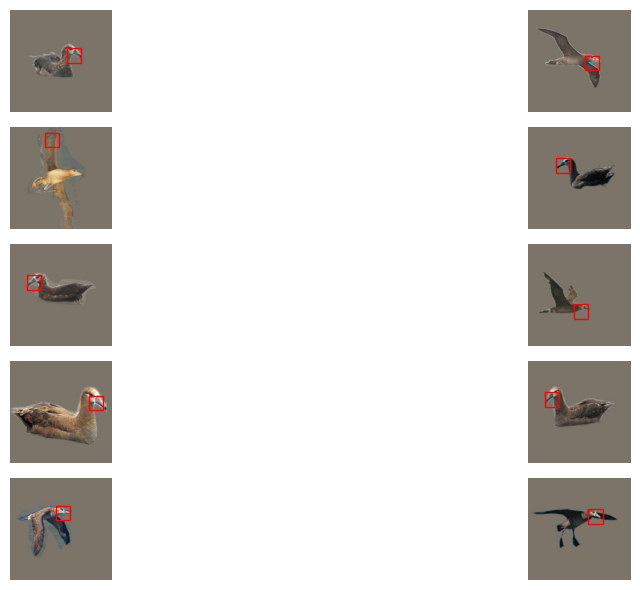

In [33]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Define a function to plot images in a grid with bounding boxes
def plot_images_with_bboxes(csv_file_path, grid_size=(5, 2), bbox_size=(64, 64)):
    # Read the CSV file
    data = pd.read_csv(csv_file_path)

    # Set up the matplotlib figure and axes based on the grid size
    fig, axes = plt.subplots(*grid_size, figsize=(15, 6))
    axes = axes.flatten()

    # Iterate over the first ten rows of the dataframe
    for i, (idx, row) in enumerate(data.head(10).iterrows()):
        # Read the image
        img_path = row['img name']
        image = Image.open(img_path)

        # Get the bounding box coordinates
        h_min = row['h_min_224']
        h_max = row['h_max_224']
        w_min = row['w_min_224']
        w_max = row['w_max_224']

        # Draw the bounding box as a rectangle
        rect = patches.Rectangle((w_min, h_min), w_max - w_min, h_max - h_min,
                                 linewidth=1, edgecolor='r', facecolor='none')

        # Plot the image and the bounding box
        axes[i].imshow(image)
        axes[i].add_patch(rect)
        axes[i].axis('off')

    # Adjust the layout
    plt.tight_layout()
    plt.show()

# Example usage
csv_file_path = '/home/harishbabu/projects/PIPNet/runs/062-CUB-18-imgnet_with-equalize-aug_cnext26_img=224_nprotos=20_no-KO_no-OOD/node_wise_top10/003+002_prototypes_top10_projectloader_last.csv'  # Replace with your CSV file path
# images_dir = 'path_to_your_images_directory'  # Replace with your images directory path
plot_images_with_bboxes(csv_file_path)


In [52]:
import os
from PIL import Image

# Define the paths to the bounding_boxes.txt and images.txt files
bounding_boxes_file = "/projects/ml4science/harishbabu/data/CUB_200_2011/bounding_boxes.txt"
images_file = "/projects/ml4science/harishbabu/data/CUB_200_2011/images.txt"  # This file contains image paths

# Create a dictionary to store image paths and dimensions
image_info = {}

# Read image paths and dimensions from the images.txt file
with open(images_file, "r") as image_file:
    for line in image_file:
        image_id, image_path = line.strip().split()
        image = Image.open(os.path.join("/projects/ml4science/harishbabu/data/CUB_200_2011/images", image_path))  # Assuming images are in a subdirectory
        image_width, image_height = image.size
        image_info[image_id] = {
            "path": image_path,
            "width": image_width,
            "height": image_height,
        }

# Create a list to store normalized bounding box coordinates
normalized_bboxes = []

# Open the bounding_boxes.txt file and process each line
with open(bounding_boxes_file, "r") as bbox_file:
    for line in bbox_file:
        components = line.strip().split()
        
        if len(components) == 5:
            image_id, x, y, width, height = map(float, components)
            
            # Get image dimensions from the dictionary
            image_data = image_info.get(image_id)
            if image_data is not None:
                image_width = image_data["width"]
                image_height = image_data["height"]
                
                # Calculate normalized coordinates
                normalized_x = x / image_width
                normalized_y = y / image_height
                normalized_width = width / image_width
                normalized_height = height / image_height
                
                # Append normalized coordinates to the list
                normalized_bboxes.append((image_id, normalized_x, normalized_y, normalized_width, normalized_height))

# Write the normalized bounding boxes to a new file "bounding_boxes_normalized.txt"
output_file = "/projects/ml4science/harishbabu/data/CUB_200_2011/bounding_boxes_normalized.txt"
with open(output_file, "w") as output:
    for bbox in normalized_bboxes:
        image_id, norm_x, norm_y, norm_width, norm_height = bbox
        output.write(f"{image_id} {norm_x} {norm_y} {norm_width} {norm_height}\n")

print(f"Normalized bounding boxes written to {output_file}")


Normalized bounding boxes written to /projects/ml4science/harishbabu/data/CUB_200_2011/bounding_boxes_normalized.txt


In [8]:
np.mean([])

/home/harishbabu/.conda/envs/hpnet1/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/harishbabu/.conda/envs/hpnet1/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


nan

In [20]:
x = set([1, 2, 3])

for _ in x:
    print(_)

1
2
3
